In [76]:
import pandas as pd
import numpy as np
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer, calculate_kmo
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore

In [77]:
# Set up file paths
os.chdir('/Users/nsusser/Desktop/Github/happyDB/')

# psych items and factors
df_main = pd.read_csv('analysis_data/results - factors.csv', encoding='latin1').sort_values(by='hmid').reset_index(drop=True)

# situational items
df_other = pd.read_csv('data/final data - other vars.csv', encoding='latin1').drop_duplicates(subset='hmid', keep='first')
df_other = df_other[df_other['hmid'].isin(set(list(df_main['hmid'])))].sort_values(by='hmid').reset_index(drop=True)
df_other.to_csv('data/filtered final data - other vars.csv', index=False)

/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3310376806.py:8: DtypeWarning: Columns (24,25,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_other = pd.read_csv('data/final data - other vars.csv', encoding='latin1').drop_duplicates(subset='hmid', keep='first')


In [78]:
predictor_cols = list(df_other.columns[10:])

correlation_results = []

# Human-readable factor names
factor_label_map = {
    "Factor 1": "Positive Emotions",
    "Factor 2": "Meaning and Mastery",
    "Factor 3": "Negative attitudes toward life",
    "Factor 4": "Close and Deep Relationships",
    "Factor 5": "Prosocial Behavior-Empathy for suffering",
    "Factor 6": "Engagement",
    "Factor 7": "Health",
    "Factor 8": "Autonomy",
    "Factor 9": "Vitality",
    "Factor 10": "Community & Belonging",
    "Factor 11": "Learning and Growth",
    "Factor 12": "Negative Emotions",
    "Factor 13": "Emotional Stability",
    "Factor 14": "Loneliness/Independence",
    "Factor 15": "Supportive Relationships",
    "Factor 16": "Autonomy-Engagement",
    "Factor 17": "Life Satisfaction",
    "Factor 18": "Trusting and Respectfully Relationships",
    "Factor 19": "Negative feelings toward self",
    "Factor 20": "Optimism",
    "Factor 21": "Resilience"
}

# Iterate over factors and compute top correlations
for fac in range(1, 22):
    factor_col = 'Factor_' + str(fac)
    readable_name = factor_label_map[f"Factor {fac}"]
    
    correlations = {}
    for col in predictor_cols:
        numeric_data = pd.to_numeric(df_other[col], errors='coerce')
        valid_indices = numeric_data.notna() & df_main[factor_col].notna()
        correlations[col] = df_main.loc[valid_indices, factor_col].corr(numeric_data.loc[valid_indices])
    
    top_5 = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
    
    print(f"FACTOR {fac} — {readable_name}")
    for col, corr in top_5:
        print(f"{col}: {corr}")
    print()
    
    for col, corr in top_5:
        correlation_results.append({
            "Factor": readable_name,
            "Predictor": col,
            "Correlation": corr
        })

# Create DataFrame and save
correlation_results_df = pd.DataFrame(correlation_results)
correlation_results_df.to_csv("factor_predictor_correlations.csv", index=False)


FACTOR 1 — Positive Emotions
positivity: 0.7295053906455742
self: 0.4986365892736391
certainty: 0.4452383857764804
episodictdetail: 0.43468047534222704
internalstimuli: 0.41293973089993874

FACTOR 2 — Meaning and Mastery
agency: 0.6075035360736433
duty: 0.5784280135106934
analyticity: 0.5321611738270448
intellect: 0.5214842652573101
goal - personal growth: 0.4351408434255529

FACTOR 3 — Negative attitudes toward life
negativity: 0.7185660559939087
adversity: 0.6045968777147893
emotion - satisfaction: -0.44587615363400906
emotion - joy: -0.4434087377458882
emotion - awkwardness: 0.43543933825424547

FACTOR 4 — Close and Deep Relationships
sociality: 0.8528301047854122
other: 0.7628746479612429
goal - friendship: 0.38243825001152926
goal - family: 0.3818665939464754
socialcontext - romantic: 0.377028417474413

FACTOR 5 — Prosocial Behavior-Empathy for suffering
moralevaluation: 0.5689395729517975
duty: 0.3077174913213904
other: 0.2735474991291317
goal - receiving from others: 0.273308807

In [79]:
# Initialize an empty DataFrame to store correlation results
correlation_matrix = pd.DataFrame(index=[f'Factor_{i}' for i in range(1, 22)], columns=predictor_cols)

# Iterate over factors and calculate correlations
for fac in range(1, 22):
    for col in predictor_cols:
        numeric_data = pd.to_numeric(df_other[col], errors='coerce')  # Convert to numeric, handling errors
        valid_indices = numeric_data.notna() & df_main[f'Factor_{fac}'].notna()  # Find valid indices
        correlation = df_main.loc[valid_indices, f'Factor_{fac}'].corr(numeric_data.loc[valid_indices])
        correlation_matrix.loc[f'Factor_{fac}', col] = correlation

# Convert to numeric and fill NaNs with 0 for clean output
correlation_matrix = correlation_matrix.apply(pd.to_numeric, errors='coerce').fillna(0)
# Rename index from 'Factor_1', 'Factor_2', ... to human-readable names
correlation_matrix.index = [factor_label_map[f"Factor {i}"] for i in range(1, 22)]
# Save the correlation matrix to a CSV file
correlation_matrix.to_excel('analysis_data/predictor_correlation_matrix.xlsx', index=True)

In [80]:
# select columns to use as predictors
#NOTE THAT FILL ZERO IS NOT THE RIGHT CHOICE  // ZSCORE ALL COLS AND THEN FILLNA WITH 0
predictors = df_other[predictor_cols].apply(pd.to_numeric, errors='coerce') 

# Apply Z-score standardization
predictors = predictors.apply(zscore, nan_policy='omit')

# handle NA values
predictors = predictors.fillna(0)
for fac in range(1,22):
    # split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(predictors, df_main['Factor_' + str(fac)], test_size=0.2, random_state=42)

    # train ridge regression model
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)

    # make predictions
    predictions = ridge.predict(X_test)
    # calculate and print out-of-sample mse and correlation
    mse = mean_squared_error(y_test, predictions)
    correlation = pd.Series(predictions).corr(pd.Series(y_test.values))
    print("FACTOR", fac)
    print(f"Out-of-sample MSE: {mse}")
    print(f"Out-of-sample correlation: {correlation}")
    print()
    print()

FACTOR 1
Out-of-sample MSE: 0.30268279368875184
Out-of-sample correlation: 0.8347043024494601


FACTOR 2
Out-of-sample MSE: 0.26745291777919683
Out-of-sample correlation: 0.8517282477081235


FACTOR 3
Out-of-sample MSE: 0.3021793883419811
Out-of-sample correlation: 0.8267953111881232


FACTOR 4
Out-of-sample MSE: 0.19661247995067535
Out-of-sample correlation: 0.893311401801927


FACTOR 5
Out-of-sample MSE: 0.39804705155699943
Out-of-sample correlation: 0.746503452891738


FACTOR 6
Out-of-sample MSE: 0.3808377746870886
Out-of-sample correlation: 0.7625833408668867


FACTOR 7
Out-of-sample MSE: 0.4868380599931836
Out-of-sample correlation: 0.6724788565667212


FACTOR 8
Out-of-sample MSE: 0.41352599545594537
Out-of-sample correlation: 0.7318793282262476


FACTOR 9
Out-of-sample MSE: 0.6317966365607426
Out-of-sample correlation: 0.540048233329204


FACTOR 10
Out-of-sample MSE: 0.43300216710080397
Out-of-sample correlation: 0.6925898983878814


FACTOR 11
Out-of-sample MSE: 0.490202852150318

In [81]:
# select columns to use as predictors
#NOTE THAT FILL ZERO IS NOT THE RIGHT CHOICE  // ZSCORE ALL COLS AND THEN FILLNA WITH 0
predictors = df_other[predictor_cols].apply(pd.to_numeric, errors='coerce') 

# Apply Z-score standardization
predictors = predictors.apply(zscore, nan_policy='omit')

# handle NA values
predictors = predictors.fillna(0)
for fac in range(1,22):
    # split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(predictors, df_main['Factor_' + str(fac)], test_size=0.2, random_state=42)

    # train ridge regression model
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)

    # make predictions
    predictions = ridge.predict(X_test)
    # calculate and print out-of-sample mse and correlation
    mse = mean_squared_error(y_test, predictions)
    correlation = pd.Series(predictions).corr(pd.Series(y_test.values))
    print("FACTOR", fac)
    print(f"Out-of-sample MSE: {mse}")
    print(f"Out-of-sample correlation: {correlation}")
    print()
    print()

FACTOR 1
Out-of-sample MSE: 0.30268279368875184
Out-of-sample correlation: 0.8347043024494601


FACTOR 2
Out-of-sample MSE: 0.26745291777919683
Out-of-sample correlation: 0.8517282477081235


FACTOR 3
Out-of-sample MSE: 0.3021793883419811
Out-of-sample correlation: 0.8267953111881232


FACTOR 4
Out-of-sample MSE: 0.19661247995067535
Out-of-sample correlation: 0.893311401801927


FACTOR 5
Out-of-sample MSE: 0.39804705155699943
Out-of-sample correlation: 0.746503452891738


FACTOR 6
Out-of-sample MSE: 0.3808377746870886
Out-of-sample correlation: 0.7625833408668867


FACTOR 7
Out-of-sample MSE: 0.4868380599931836
Out-of-sample correlation: 0.6724788565667212


FACTOR 8
Out-of-sample MSE: 0.41352599545594537
Out-of-sample correlation: 0.7318793282262476


FACTOR 9
Out-of-sample MSE: 0.6317966365607426
Out-of-sample correlation: 0.540048233329204


FACTOR 10
Out-of-sample MSE: 0.43300216710080397
Out-of-sample correlation: 0.6925898983878814


FACTOR 11
Out-of-sample MSE: 0.490202852150318

In [82]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Set working directory
os.chdir('/Users/nsusser/Desktop/Github/happyDB/')

# Merge the datasets on the unique identifier "hmid"
df_merged = pd.merge(df_main, df_other, on='hmid', how='inner')

# Identify columns after the first three
candidate_cols = df_merged.columns[3:]

# Filter only numeric ones
numeric_cols = df_merged[candidate_cols].select_dtypes(include=[np.number]).columns

# Copy original merged DataFrame
df_standardized = df_merged.copy()


# Apply standardization only to numeric predictor columns
scaler = StandardScaler()
df_standardized[numeric_cols] = scaler.fit_transform(df_merged[numeric_cols])



In [83]:
def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'



In [84]:
def plot_predictors_against_factor(
    df, predictors, target_factor, target_label="Target Factor",
    title_prefix="Predictors vs Factor", display_table=True
):
    grid_data_list = []
    summary_stats = [] 


    for predictor in predictors:
        temp_df = df[[predictor, target_factor]].dropna()
        X = temp_df[predictor].astype(float)
        y = temp_df[target_factor].astype(float)
        X_const = sm.add_constant(X)
        model = sm.OLS(y, X_const).fit()

        x_grid = np.linspace(X.min(), X.max(), 100)
        X_new = sm.add_constant(x_grid)
        pred_summary = model.get_prediction(X_new).summary_frame(alpha=0.05)

        temp_grid = pd.DataFrame({
            "X": x_grid,
            "Y": pred_summary["mean"].values.astype(float),
            "Lower CI": pred_summary["obs_ci_lower"].values.astype(float),
            "Upper CI": pred_summary["obs_ci_upper"].values.astype(float),
            "Predictor": predictor
        })

        grid_data_list.append(temp_grid)

        summary_stats.append({
            "Predictor": predictor,
            "Coefficient": model.params[1],
            "P-Value": model.pvalues[1],
            "R-squared": model.rsquared
        })


    grid_data = pd.concat(grid_data_list, ignore_index=True)
    grid_data["Predictor Label"] = grid_data["Predictor"].apply(
        lambda x: x.split(" - ")[-1].capitalize() if " - " in x else x.capitalize()
    )

    plt.style.use('seaborn-v0_8-whitegrid')

    def plot_shaded(data, color, **kwargs):
        data = data.sort_values("X")
        plt.plot(data["X"], data["Y"], color=color, lw=2)
        plt.fill_between(data["X"], data["Lower CI"], data["Upper CI"], color=color, alpha=0.2)

    g = sns.FacetGrid(
        grid_data, col="Predictor Label", col_wrap=3,
        height=3.8, aspect=1.25, margin_titles=True, despine=False
    )
    g.map_dataframe(plot_shaded)
    g.set_titles(col_template="{col_name}", size=24)

    g.fig.suptitle(f"{title_prefix} of {target_label}",
                   fontsize=48, y=1.12, fontweight='bold', color='#333333')
    g.fig.text(0.5, 0.00, "Predictor Score",
               ha='center', fontsize=26, fontweight='bold', color='#333333')
    g.fig.text(0.00, 0.5, target_label,
               va='center', rotation='vertical', fontsize=26, fontweight='bold', color='#333333')

    plt.tight_layout()
    plt.subplots_adjust(top=0.90, bottom=0.12, left=0.06)
    plt.show()

    # === Summary Table ===
    summary_df = pd.DataFrame(summary_stats)
    summary_df["Predictor Label"] = summary_df["Predictor"].apply(
        lambda x: x.split(" - ")[-1].capitalize() if " - " in x else x.capitalize()
    )

    def significance_stars(p):
        if p < 0.001: return '***'
        elif p < 0.01: return '**'
        elif p < 0.05: return '*'
        else: return 'ns'

    summary_df["Significance"] = summary_df["P-Value"].apply(significance_stars)

    styled = (
        summary_df[["Predictor Label", "Coefficient", "P-Value", "R-squared", "Significance"]]
        .sort_values("P-Value")
        .style
        .set_caption("Regression Summary with P-Values and Significance")
        .format({
            "Coefficient": "{:.3f}",
            "P-Value": "{:.2e}",
            "R-squared": "{:.3f}"
        })
        .hide(axis="index")
        .set_table_styles([
            {"selector": "caption", "props": [("font-size", "18px"), ("font-weight", "bold"), ("color", "#333")]},
            {"selector": "th", "props": [("text-align", "center"), ("background-color", "#f0f0f0")]}
        ])
        .applymap(lambda val: "font-weight: bold; color: #d62728" if isinstance(val, str) and "***" in val else "")
        .set_properties(**{
            "text-align": "center",
            "font-size": "12px",
            "border": "1px solid #ccc",
            "padding": "6px"
        })
    )

    if display_table:
        display(styled)

    return summary_df[["Predictor Label", "Coefficient", "P-Value", "R-squared", "Significance"]]


/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Coefficient": model.params[1],
/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "P-Value": model.pvalues[1],
/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.i

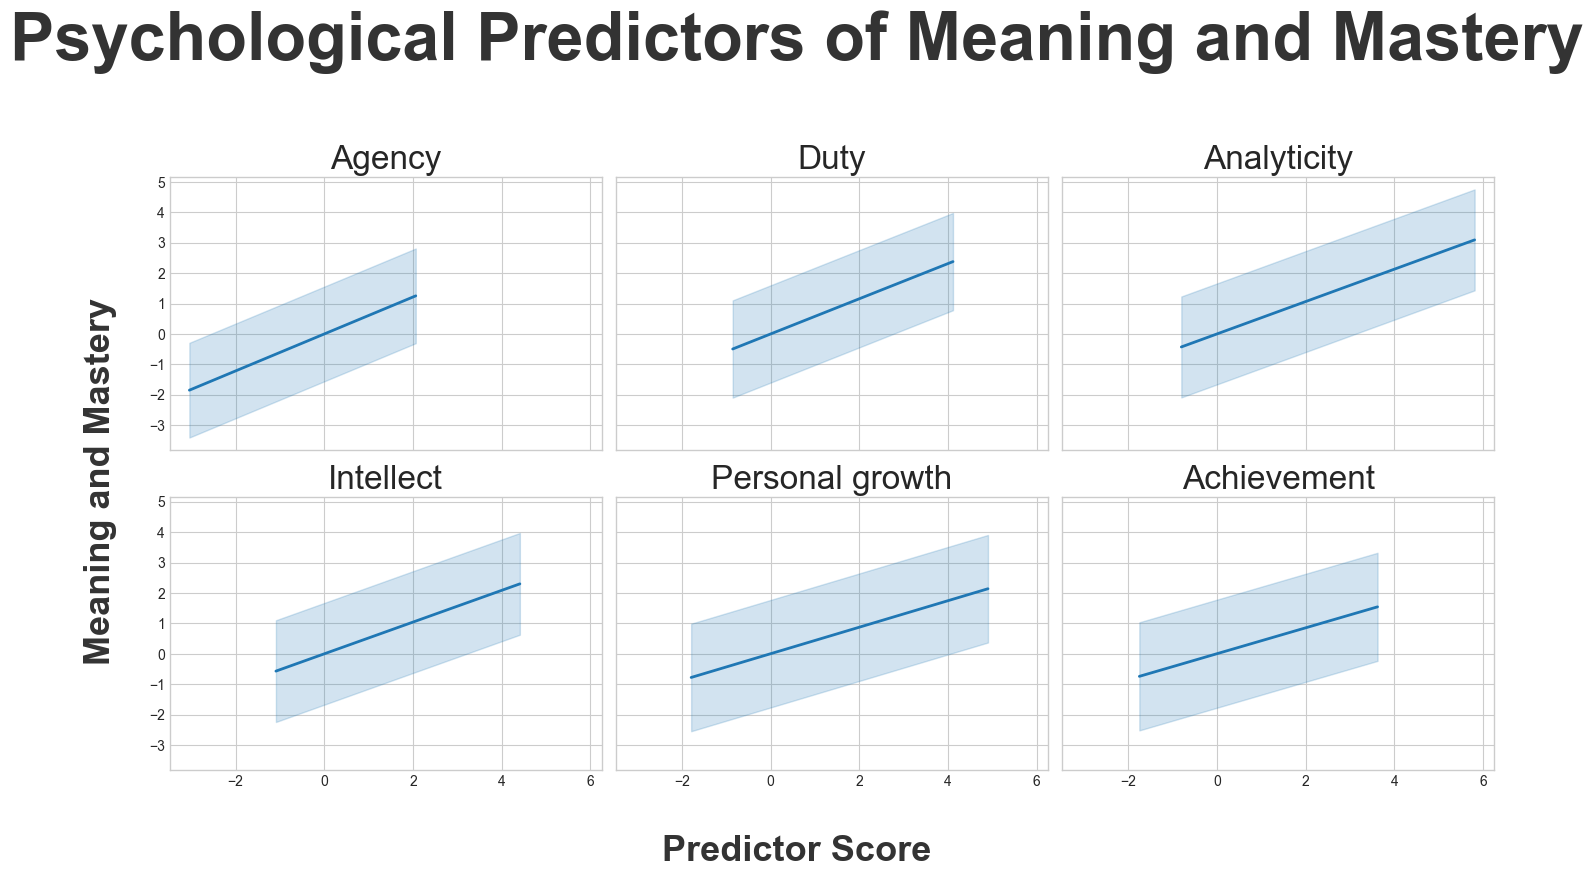

/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:97: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda val: "font-weight: bold; color: #d62728" if isinstance(val, str) and "***" in val else "")


Predictor Label,Coefficient,P-Value,R-squared,Significance
Agency,0.608,0.00e+00,0.369,***
Duty,0.578,0.00e+00,0.335,***
Analyticity,0.532,0.00e+00,0.283,***
Intellect,0.521,0.00e+00,0.272,***
Personal growth,0.436,0.00e+00,0.189,***
Achievement,0.425,0.00e+00,0.180,***


,Predictor Label,Coefficient,P-Value,R-squared,Significance
0,Agency,6.075e-01,0.000e+00,3.691e-01,***
1,Duty,5.784e-01,0.000e+00,3.346e-01,***
2,Analyticity,5.322e-01,0.000e+00,2.832e-01,***
3,Intellect,5.215e-01,0.000e+00,2.719e-01,***
4,Personal growth,4.358e-01,0.000e+00,1.893e-01,***
5,Achievement,4.254e-01,0.000e+00,1.805e-01,***


In [85]:
meaningful_items = [
    "agency", "duty", "analyticity",
    "intellect", "goal - personal growth", "goal - achievement"
]

plot_predictors_against_factor(
    df=df_standardized,
    predictors=meaningful_items,
    target_factor="Factor_2",
    target_label="Meaning and Mastery",
    title_prefix="Psychological Predictors",
    display_table=True
)


/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Coefficient": model.params[1],
/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "P-Value": model.pvalues[1],
/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.i

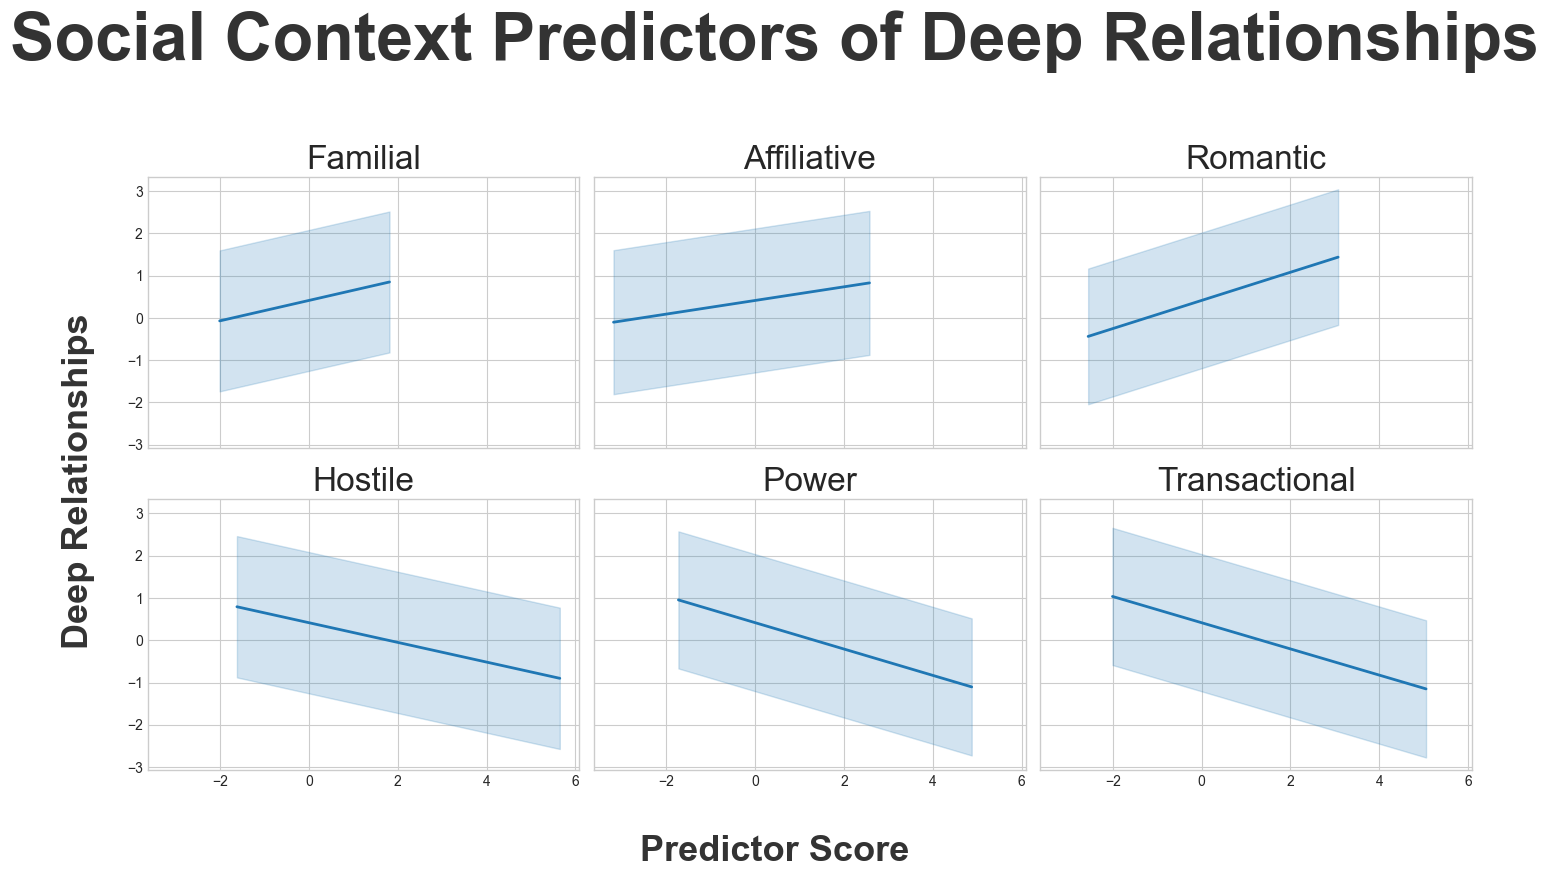

/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:97: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda val: "font-weight: bold; color: #d62728" if isinstance(val, str) and "***" in val else "")


Predictor Label,Coefficient,P-Value,R-squared,Significance
Familial,0.241,0.00e+00,0.074,***
Affiliative,0.161,0.00e+00,0.033,***
Romantic,0.333,0.00e+00,0.142,***
Hostile,-0.233,0.00e+00,0.069,***
Power,-0.312,0.00e+00,0.124,***
Transactional,-0.310,0.00e+00,0.123,***


/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Coefficient": model.params[1],
/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "P-Value": model.pvalues[1],
/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.i

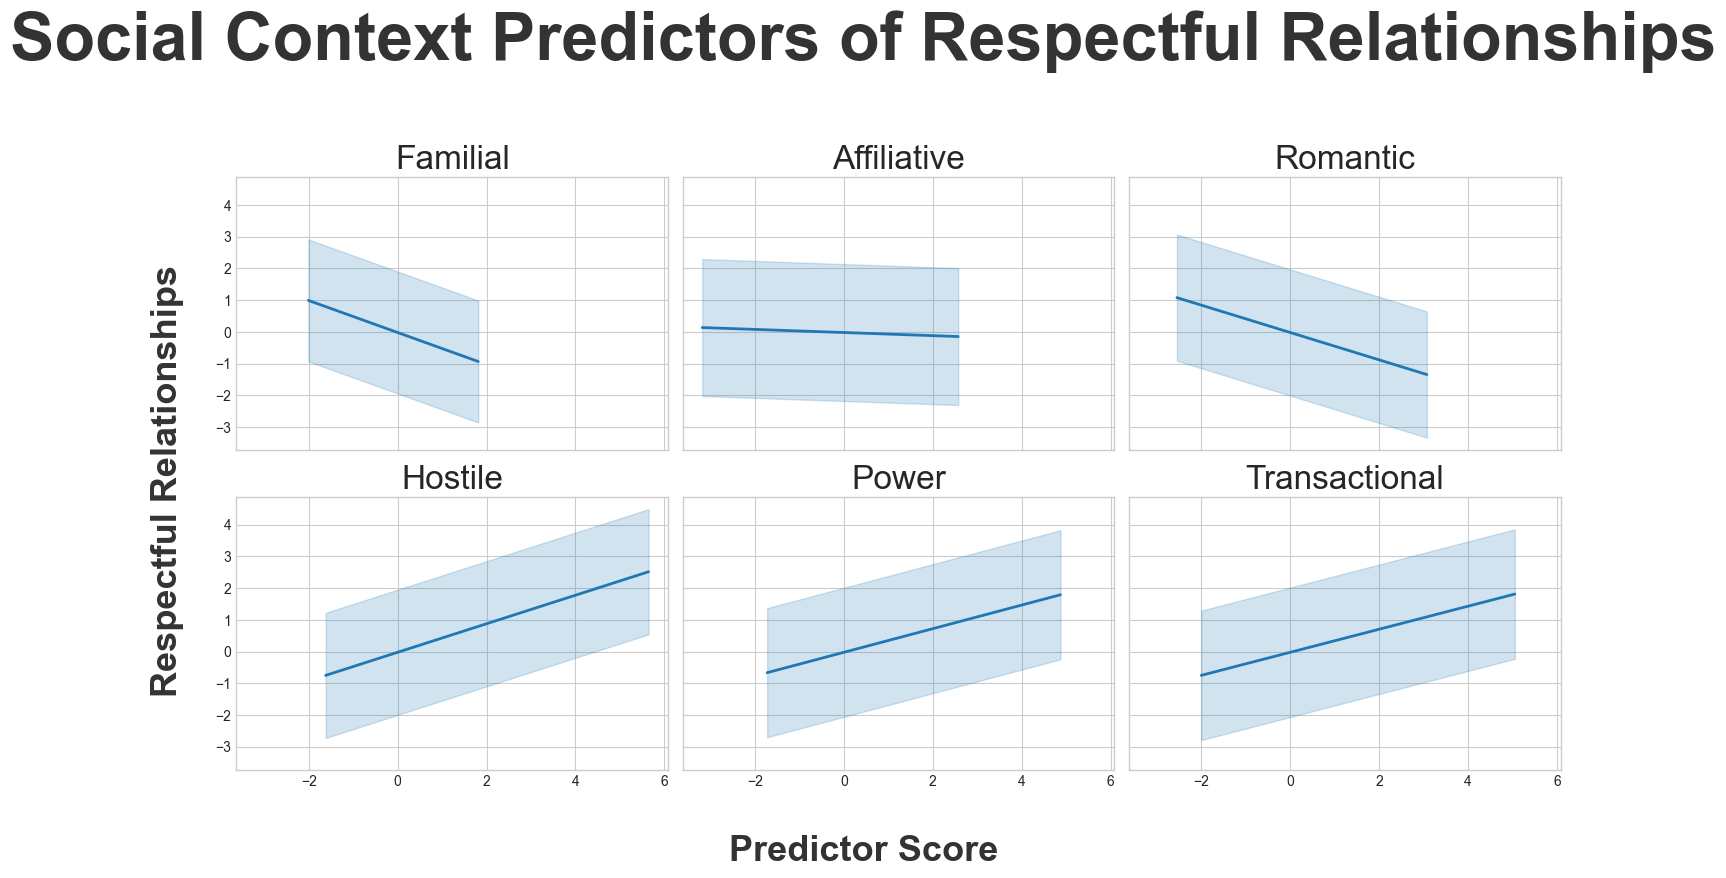

/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:97: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda val: "font-weight: bold; color: #d62728" if isinstance(val, str) and "***" in val else "")


Predictor Label,Coefficient,P-Value,R-squared,Significance
Familial,-0.504,0.00e+00,0.209,***
Romantic,-0.431,0.00e+00,0.153,***
Hostile,0.449,0.00e+00,0.166,***
Power,0.372,0.00e+00,0.114,***
Transactional,0.363,0.00e+00,0.108,***
Affiliative,-0.049,2.08e-32,0.002,***


/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Coefficient": model.params[1],
/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "P-Value": model.pvalues[1],
/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.i

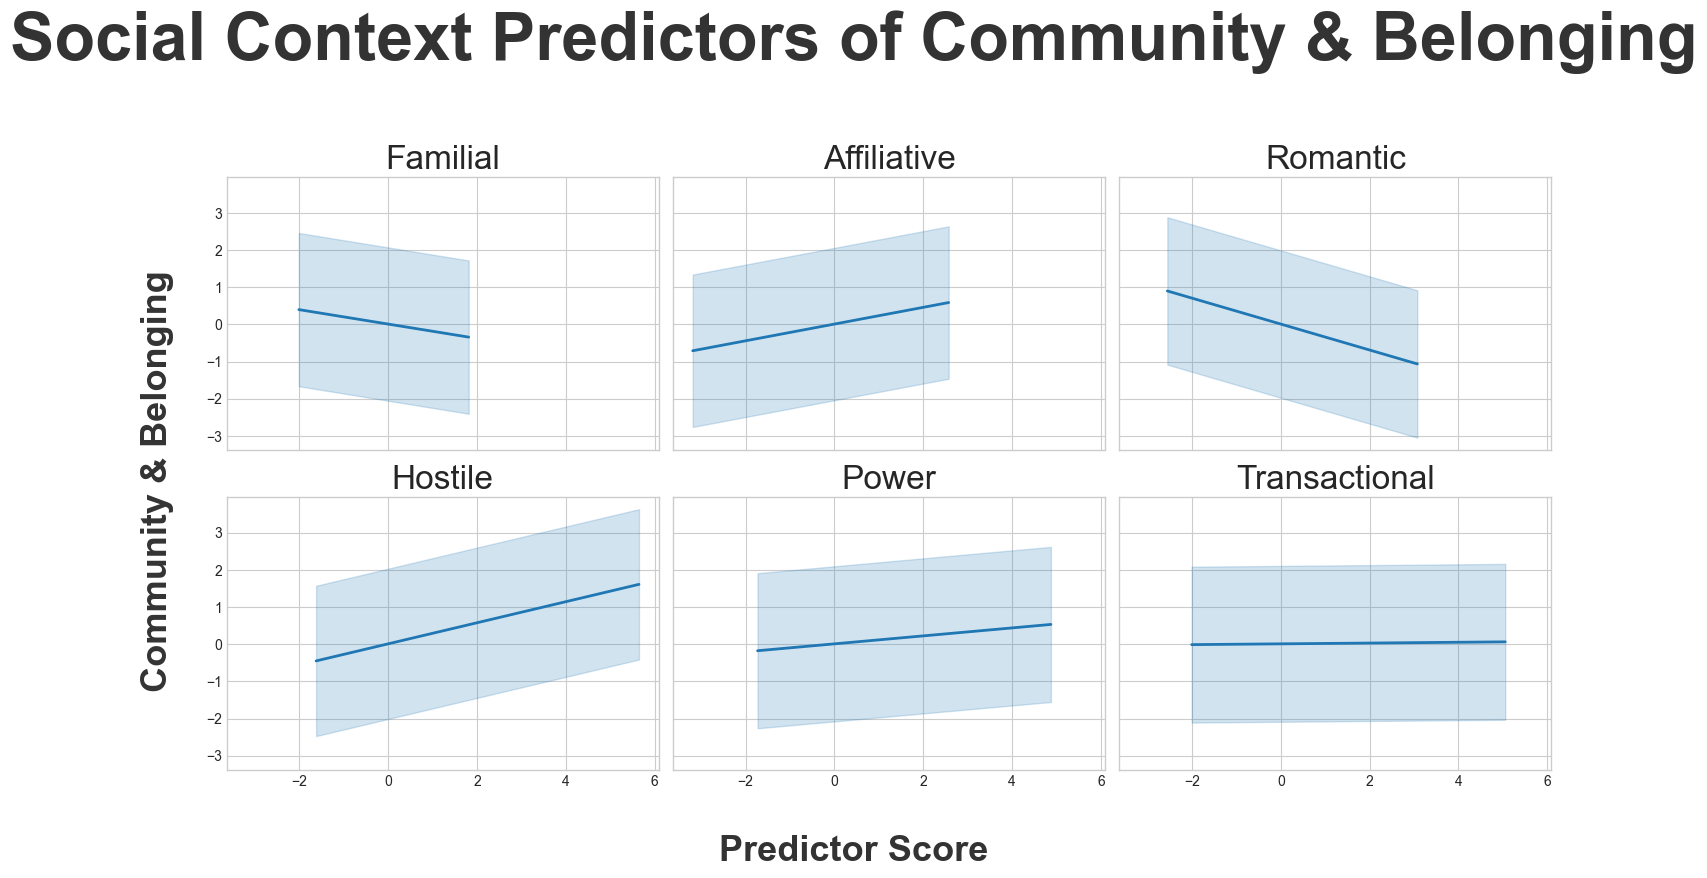

/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:97: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda val: "font-weight: bold; color: #d62728" if isinstance(val, str) and "***" in val else "")


Predictor Label,Coefficient,P-Value,R-squared,Significance
Familial,-0.194,0.00e+00,0.033,***
Affiliative,0.225,0.00e+00,0.044,***
Romantic,-0.349,0.00e+00,0.106,***
Hostile,0.283,0.00e+00,0.070,***
Power,0.107,1.04e-156,0.010,***
Transactional,0.011,8.25e-03,0.000,**


/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Coefficient": model.params[1],
/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "P-Value": model.pvalues[1],
/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.i

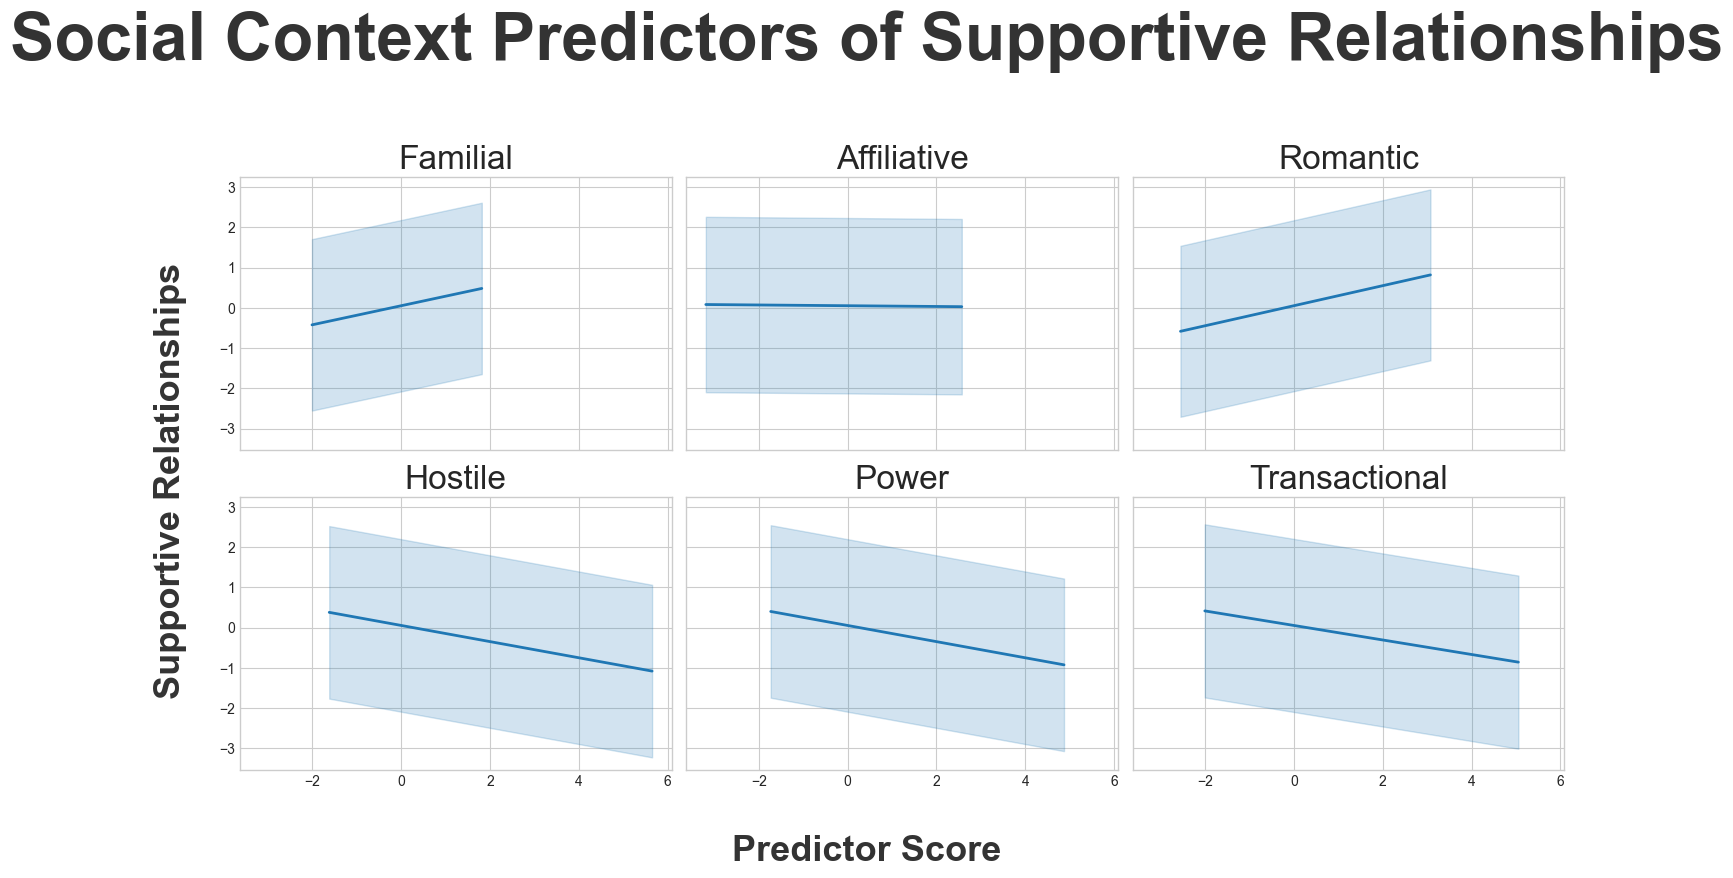

/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_40767/3762277011.py:97: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda val: "font-weight: bold; color: #d62728" if isinstance(val, str) and "***" in val else "")


Predictor Label,Coefficient,P-Value,R-squared,Significance
Familial,0.237,0.00e+00,0.045,***
Romantic,0.249,0.00e+00,0.050,***
Hostile,-0.201,0.00e+00,0.033,***
Power,-0.201,0.00e+00,0.033,***
Transactional,-0.180,0.00e+00,0.026,***
Affiliative,-0.009,2.65e-02,0.000,*


In [86]:
relationship_factors = {
    "Deep Relationships": "Factor_4",
    "Respectful Relationships": "Factor_18",
    "Community & Belonging": "Factor_10",
    "Supportive Relationships": "Factor_15"
}

# Define the social context variables (ensure these column names match your dataset)
socialcontext_cols = [
    "socialcontext - familial",
    "socialcontext - affiliative",
    "socialcontext - romantic",
    "socialcontext - hostile",
    "socialcontext - power",
    "socialcontext - transactional"
]

for factor_label, factor_col in relationship_factors.items():
    plot_predictors_against_factor(
        df=df_standardized,
        predictors=socialcontext_cols,
        target_factor=factor_col,
        target_label=factor_label,
        title_prefix="Social Context Predictors",
        display_table=True
    )
